# Machine Learning Pipeline for Fatigue Prediction in the full IBD Cohort

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    recall_score,
    auc,
    roc_curve,
    roc_auc_score,
)
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import shap

from sklearn.model_selection import (
    cross_val_score,
    GridSearchCV,
    GroupShuffleSplit,
    GroupKFold,
)
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers, regularizers
import tensorflow as tf
import datetime
from tensorflow.keras.metrics import AUC
import keras_tuner as kt

/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Pipeline Configuration

In [2]:
random_seed = 1337  # Random seed to ensure reproducibility
output_path = "output/tensorflow_keras_tuner/"
cmap = "seismic"  # Colormap for SHAP plots use "seismic" for full cohort and "berlin" for biochem remission cohort
file_prefix="tensorflow"
# file_prefix = "biochem_remission"

## Data Loading

In [3]:
df = pd.read_csv("working_data/all_ibd_ml_input.csv")
# df = df[df["aggregate_disease_activity_Biochemical remission"] == 1] # Uncomment to run biochem remission pipeline

## Further Data Pre-Processing

In [4]:
# convert categorical columns to numerical
df["sex"] = df["sex"].map({"Male": 1, "Female": 0})
df["fatigue_outcome"] = df["fatigue_outcome"].map({"fatigue": 1, "no_fatigue": 0})

In [5]:
# These columns are not features we want to use in the model
# Aggregate disease activity in some ways is a reflection of the other raw variables
columns_to_drop = [
    "aggregate_disease_activity_Active",
    "aggregate_disease_activity_Biochemical remission",
    "aggregate_disease_activity_Remission",
    "season_no_data",
    "study",
    "redcap_event_name_timepoint_1",
    "redcap_event_name_timepoint_2",
    "redcap_event_name_timepoint_3",
    "redcap_event_name_timepoint_4",
    "redcap_event_name_timepoint_5",
]

df.drop(columns=columns_to_drop, inplace=True)

In [6]:
# This column is dropped as all the values are 0.
columns_to_drop = [
    "baseline_eims_pyoderma_gangrenosum",
]

df.drop(columns=columns_to_drop, inplace=True)

## Create Train and Test Datasets

GroupShuffleSplit used to ensure same participant only appears in either train or test set.

In [7]:
# Create Train Validate and Test Datasets

# First split into train and temp 70% train, 30% temp which will be split 50:50 into 15% val and 15% test

# GroupShuffleSplit
splitter = GroupShuffleSplit(test_size=0.36, n_splits=1, random_state=random_seed)

# Perform the split
for train_idx, test_idx in splitter.split(df, groups=df["study_id"]):
    train_data = df.iloc[train_idx]
    temp_data = df.iloc[test_idx]

# Drop 'study_id' from X_train and X_test as it's not a feature
X_train = train_data.drop(columns=["fatigue_outcome", "study_id"])
y_train = train_data["fatigue_outcome"]

groups = train_data["study_id"]  # Group variable for GroupKFold cross-validation

temp_data_splitter = GroupShuffleSplit(
    test_size=0.56, n_splits=1, random_state=random_seed
)

# Perform the split
for val_idx, test_idx in temp_data_splitter.split(
    temp_data, groups=temp_data["study_id"]
):
    val_data = df.iloc[val_idx]
    test_data = df.iloc[test_idx]

X_val = val_data.drop(columns=["fatigue_outcome", "study_id"])
y_val = val_data["fatigue_outcome"]

X_test = test_data.drop(columns=["fatigue_outcome", "study_id"])
y_test = test_data["fatigue_outcome"]


In [8]:
print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)
print("Test shape:", X_test.shape)

Train shape: (768, 80)
Val shape: (186, 80)
Test shape: (261, 80)


In [9]:
numerical_features = [
    "age",
    "height",
    "weight",
    "bmi",
    "age_at_diagnosis",
    "albumin",
    "crp",
    "haemoglobin",
    "red_cell_count",
    "haematocrit",
    "white_cell_count",
    "neutrophils",
    "lymphocytes",
    "monocytes",
    "eosinophils",
    "basophils",
    "platelets",
    "urea",
    "creatinine",
    "sodium",
    "potassium",
    "calprotectin",
    "ada_drug_level",
    "ifx_drug_level",
    "diagnosis_year",
    "disease_duration_weeks",
]
train_scaler = StandardScaler()  # We have tried a variety of scaling methods and they did not affect final model output
train_scaler.fit(X_train[numerical_features])
X_train[numerical_features] = train_scaler.transform(X_train[numerical_features])

test_scaler = StandardScaler()
test_scaler.fit(X_test[numerical_features])
X_test[numerical_features] = test_scaler.transform(X_test[numerical_features])

val_scaler = StandardScaler()
val_scaler.fit(X_val[numerical_features])
X_val[numerical_features] = val_scaler.transform(X_val[numerical_features])


## Deep Learning with TensorFlow


In [10]:
def model_builder(hp):
  model = keras.Sequential()

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=64, max_value=400, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dropout(0.3))

  hp_units_2 = hp.Int('units_2', min_value=64, max_value=400, step=32)
  model.add(keras.layers.Dense(units=hp_units_2, activation='relu'))
  model.add(keras.layers.Dropout(0.3))

  model.add(keras.layers.Dense(1, activation='sigmoid'))

  model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=[AUC()])

  return model

In [11]:
tuner = kt.Hyperband(model_builder,
                     objective='val_auc',
                     max_epochs=50,
                     factor=3,
                     directory='working_data/keras_tuner',
                     project_name='keras_tuner')

Reloading Tuner from working_data/keras_tuner/keras_tuner/tuner0.json


In [12]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="auc", patience=10, restore_best_weights=True, mode="max")

In [13]:
tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping_callback])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal number of units in the second densely-connected layer is {best_hps.get('units_2')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 384 and the optimal number of units in the second densely-connected layer is 352.



### Model Definition

In [14]:
model = tuner.hypermodel.build(best_hps)


In [15]:
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping_callback],
)

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc_1: 0.6846 - loss: 0.6359 - val_auc_1: 0.7306 - val_loss: 0.5964
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_1: 0.7913 - loss: 0.5607 - val_auc_1: 0.7552 - val_loss: 0.5961
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_1: 0.8246 - loss: 0.5175 - val_auc_1: 0.7768 - val_loss: 0.5663
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_1: 0.8647 - loss: 0.4661 - val_auc_1: 0.7881 - val_loss: 0.5656
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_1: 0.8722 - loss: 0.4533 - val_auc_1: 0.8133 - val_loss: 0.5271
Epoch 6/20
 1/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - auc_1: 0.9020 - loss: 0.3963

/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `auc` which is not available. Available metrics are: auc_1,loss,val_auc_1,val_loss
  current = self.get_monitor_value(logs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_1: 0.8837 - loss: 0.4313 - val_auc_1: 0.8164 - val_loss: 0.5254
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_1: 0.9085 - loss: 0.3942 - val_auc_1: 0.8153 - val_loss: 0.5291
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_1: 0.9137 - loss: 0.3785 - val_auc_1: 0.8268 - val_loss: 0.5224
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_1: 0.9389 - loss: 0.3285 - val_auc_1: 0.8408 - val_loss: 0.4993
Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_1: 0.9328 - loss: 0.3355 - val_auc_1: 0.8434 - val_loss: 0.5211
Epoch 11/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_1: 0.9265 - loss: 0.3425 - val_auc_1: 0.8524 - val_loss: 0.5085
Epoch 12/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_1: 0.9498 - loss: 0.2929 - val_auc_1: 0.8571 - val_loss: 0.5157
Epoch 13/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_1: 0.9527 - loss: 0.2812 - val_auc_1: 0.8686 - val_loss: 0.4824
Epoch 14/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/s

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (32, 384)              │        31,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 384)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 352)              │       135,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (32, 352)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 1)                │           353 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 333,956 (1.27 MB)

 Trainable params: 166,977 (652.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 166,979 (652.27 KB)

In [17]:
history_dict = history.history
history_dict.keys()

dict_keys(['auc_1', 'loss', 'val_auc_1', 'val_loss'])

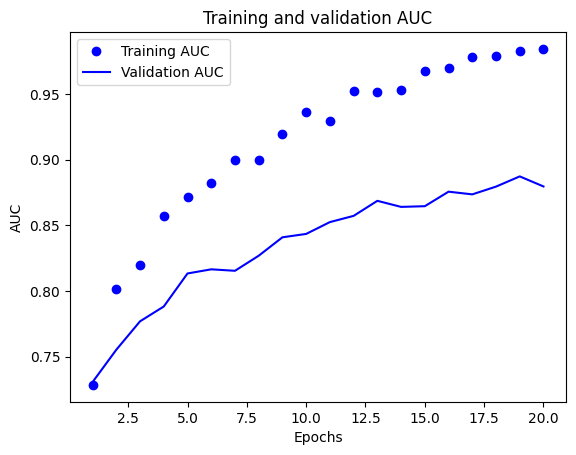

In [18]:
auc_values = history_dict["auc_1"]
val_auc_values = history_dict["val_auc_1"]
epochs = range(1, len(auc_values) + 1)
plt.plot(epochs, auc_values, "bo", label="Training AUC")
plt.plot(epochs, val_auc_values, "b", label="Validation AUC")
plt.title("Training and validation AUC")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend()

save_path = output_path + file_prefix + "_training_vs_validation_auc.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

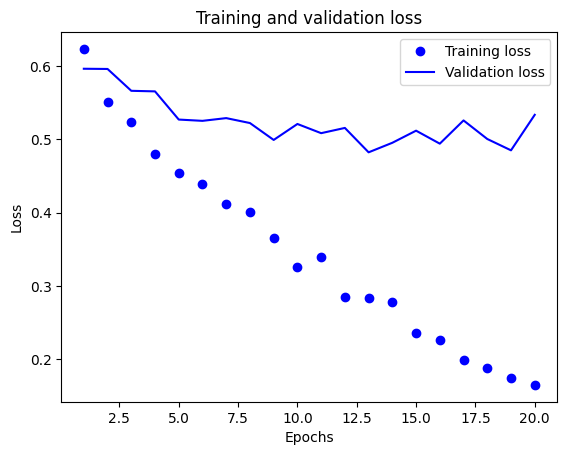

In [19]:
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

save_path = output_path + file_prefix + "_training_vs_validation_loss.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

In [21]:
results = model.evaluate(X_test, y_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_1: 0.8806 - loss: 0.6122 


In [22]:
y_pred = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_pred)

y_classes = np.where(y_pred > 0.5, 1,0)

tn, fp, fn, tp = confusion_matrix(y_test, y_classes).ravel()

# Calculate metrics
accuracy = accuracy_score(y_test, y_classes)
sensitivity = recall_score(y_test, y_classes)  # TPR
specificity = tn / (tn + fp)  # TN

print("Accuracy:", accuracy)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("AUC:", test_auc)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy: 0.8237547892720306
Sensitivity: 0.8415841584158416
Specificity: 0.8125
AUC: 0.8779084158415842


In [23]:
np.savetxt(output_path + "dnn_fpr.txt", fpr)
np.savetxt(output_path + "dnn_tpr.txt", tpr)

with open(output_path + "dnn_auc.txt", "w") as f:
    f.write(str(test_auc))

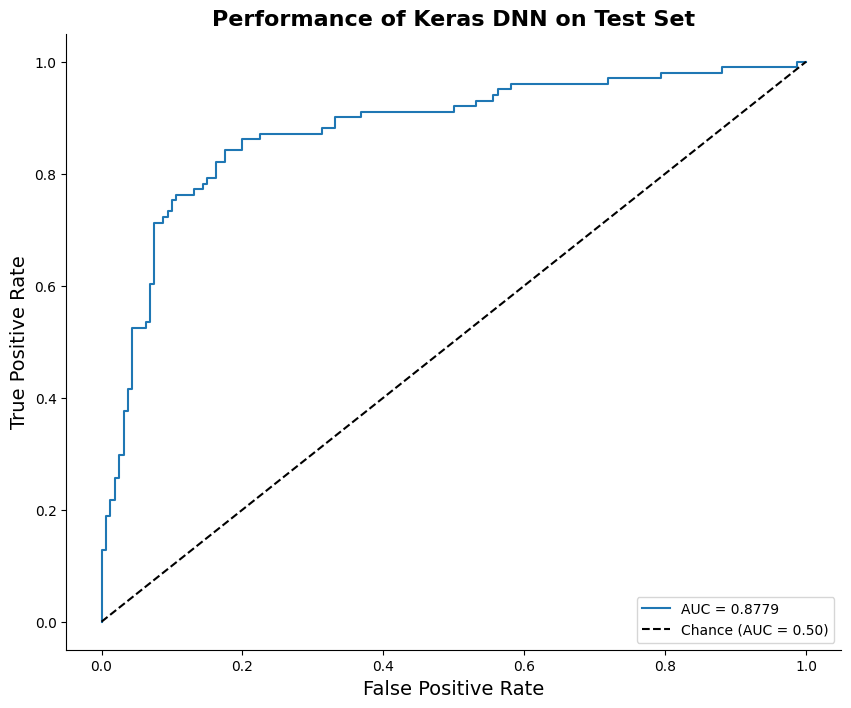

In [24]:
plt.figure(figsize=(10, 8))

plt.plot(fpr, tpr,
    label=f"AUC = {test_auc:.4f}",
)

# Add baseline and plot details
plt.plot([0, 1], [0, 1], "k--", label="Chance (AUC = 0.50)")
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("Performance of Keras DNN on Test Set", fontsize=16, fontweight="bold")
plt.legend(loc="lower right")

# Remove the top and right spines
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Define the absolute path
save_path = f"{output_path}{file_prefix}_roc_curves.png"

# Save the plot to the specified path
plt.savefig(save_path, dpi=300, bbox_inches="tight")

# Display the plot
plt.show()

## View Tensorboard Output

To launch tensorboard run the following in terminal:

```bash
tensorboard --logdir logs/
```

## SHAP Analysis on Keras DNN Model

In [25]:
explainer = shap.KernelExplainer(model, X_test)
shap_values = explainer.shap_values(X_test)

Using 261 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 261/261 [05:52<00:00,  1.35s/it]


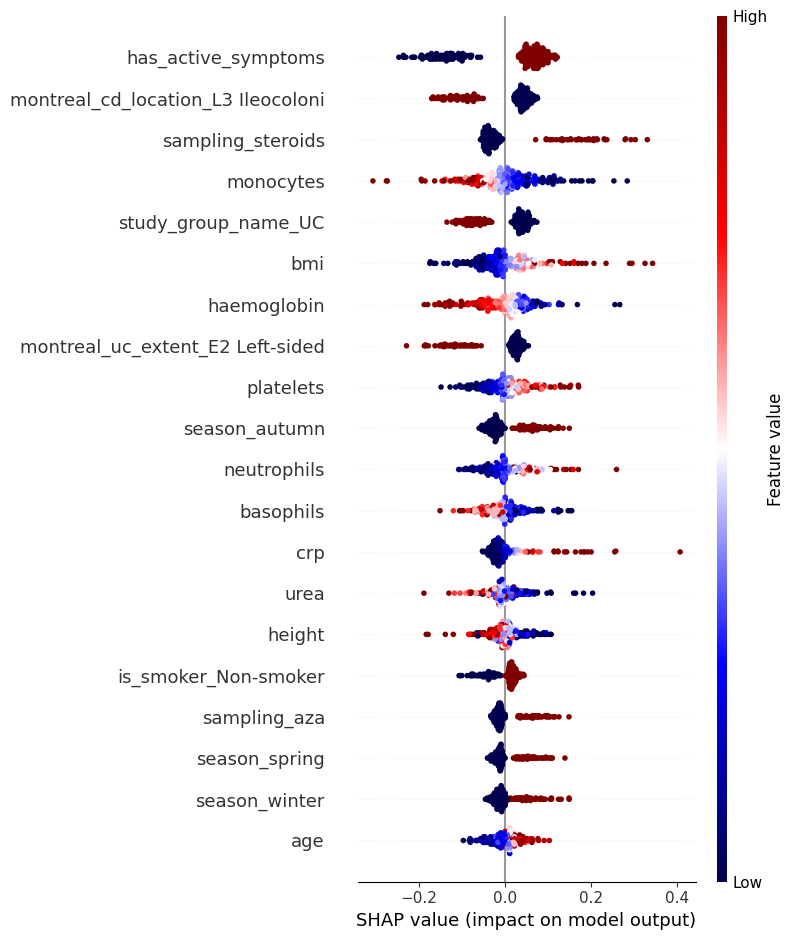

In [26]:
shap_values_class_1 = shap_values[:, :, 0]
shap.summary_plot(
    shap_values_class_1,
    X_test,
    feature_names=X_test.columns,
    show=False,
    cmap=cmap,
)

# plt.title("Keras DNN Classifier", fontsize=20, pad=20, loc="left")

save_path = f"{output_path}shap_keras_dnn.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

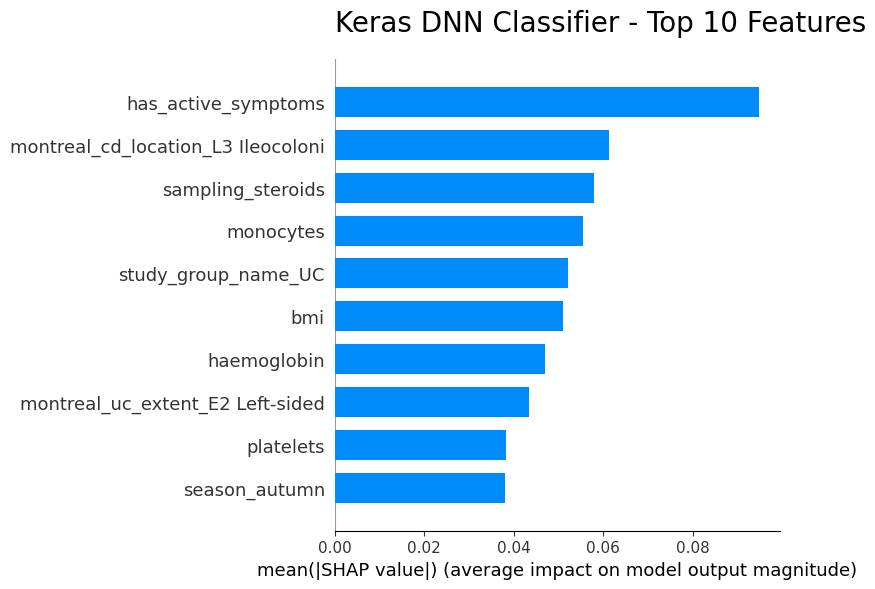

In [27]:
shap.summary_plot(
    shap_values_class_1,
    X_test,
    feature_names=X_test.columns,
    show=False,
    cmap=cmap,
    plot_type="bar",
    max_display=10,
)


plt.title("Keras DNN Classifier - Top 10 Features", fontsize=20, pad=20, loc="left")

save_path = f"{output_path}shap_keras_dnn_barplot.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

In [28]:
shap.initjs()

In [29]:
X_test_reverted = X_test

In [30]:
X_test_reverted[numerical_features] = test_scaler.inverse_transform(X_test[numerical_features])

In [31]:
X_test_reverted[numerical_features] = X_test_reverted[numerical_features].round(2)

In [33]:
patient = 6

for i in range(40):
    shap.force_plot(
        explainer.expected_value[0],
        shap_values_class_1[i],
        X_test_reverted.iloc[i],
        matplotlib=True,
        contribution_threshold=0.05,
        text_rotation=30,
        show=False,
    )

    save_path = f"{output_path}forceplots/keras_dnn_forceplot_{i}.png"
    plt.savefig(save_path, dpi=150, bbox_inches="tight")

/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/site-packages/shap/plots/_force_matplotlib.py:347: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=figsize)


## SHAP Deep Explainer

Deep explainer is much faster than kernel explainer to compute
However it is an approximation and therefore it's results are not the same as kernel explainer

In [31]:
# X_train_sample = shap.sample(X_train, 100)

# X_train_sample_np_array = X_train_sample.to_numpy()
# deep_explainer = shap.DeepExplainer(model, X_train_sample_np_array)
# shap_values = deep_explainer.shap_values(X_train_sample_np_array, output_rank_order="max_abs")

In [32]:
# shap_values_class_1 = shap_values[:, :, 0]
# shap.summary_plot(
#     shap_values_class_1,
#     X_train_sample,
#     feature_names=X_train_sample.columns,
#     show=False,
#     cmap=cmap,
# )

# plt.title("Keras DNN Classifier", fontsize=20, pad=20, loc="left")

# # save_path = f"{output_path}shap_keras_dnn.png"
# # plt.savefig(save_path, dpi=300, bbox_inches="tight")
# plt.show()

In [33]:
# Find incorrect predictions

outcomes = pd.concat([y_test, pd.Series(y_classes.ravel(), index=y_test.index)], axis=1)
outcomes.columns = ["true", "predicted"]

incorrect_predictions = outcomes[outcomes["true"] != outcomes["predicted"]]
incorrect_predictions = incorrect_predictions.join(X_test_reverted)
incorrect_predictions.to_csv( f"{output_path}forceplots/incorrect_predictions/incorrect_predictions.csv", index=False)
shap_values_incorrect_predictions = pd.DataFrame(shap_values_class_1, index=y_test.index)
shap_values_incorrect_predictions = shap_values_incorrect_predictions.loc[incorrect_predictions.index]
shap_values_incorrect_predictions = shap_values_incorrect_predictions.to_numpy()
X_test_reverted_incorrect_predictions = X_test_reverted.loc[incorrect_predictions.index]
X_test_reverted_incorrect_predictions.reset_index(inplace=True)
X_test_reverted_incorrect_predictions.drop(columns=["index"], inplace=True)

In [35]:
for i in range(len(shap_values_incorrect_predictions)):
    shap.force_plot(
        explainer.expected_value[0],
        shap_values_incorrect_predictions[i],
        X_test_reverted_incorrect_predictions.iloc[i],
        matplotlib=True,
        contribution_threshold=0.05,
        text_rotation=30,
        show=False,
    )

    save_path = f"{output_path}forceplots/incorrect_predictions/keras_dnn_forceplot_{i}.png"
    plt.savefig(save_path, dpi=150, bbox_inches="tight")